# Lab | Making predictions with logistic regression

<font color='green'>week4 day2</font> 

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

## Import libraries and select the directory

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import getpass #to get the password without it being visible
password = getpass.getpass()

········


In [3]:
# define a connection string 
# dialect/language + driver/tool :// username : password @host : db name
connection_string = 'mysql+pymysql://gloriaibars:' + password + '@127.0.0.1/sakila'
engine = create_engine(connection_string)

### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. 
### Read the data into a Pandas dataframe.

In [4]:
#show film table - film dataframe creation 
df_film = pd.read_sql_query('Select * from film', engine)
df_film

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2006-02-15 05:03:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,A Unbelieveable Yarn of a Boat And a Database ...,2006,1,None,6,0.99,183,9.99,G,"Trailers,Behind the Scenes",2006-02-15 05:03:42
996,997,YOUTH KICK,A Touching Drama of a Teacher And a Cat who mu...,2006,1,None,4,0.99,179,14.99,NC-17,"Trailers,Behind the Scenes",2006-02-15 05:03:42
997,998,ZHIVAGO CORE,A Fateful Yarn of a Composer And a Man who mus...,2006,1,None,6,0.99,105,10.99,NC-17,Deleted Scenes,2006-02-15 05:03:42
998,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,2006,1,None,5,2.99,101,28.99,R,"Trailers,Deleted Scenes",2006-02-15 05:03:42


In [5]:
#show inventory table - film dataframe creation
df_inventory = pd.read_sql_query('Select * from inventory', engine)
df_inventory

,inventory_id,film_id,store_id,last_update
0,1,1,1,2006-02-15 05:09:17
1,2,1,1,2006-02-15 05:09:17
2,3,1,1,2006-02-15 05:09:17
3,4,1,1,2006-02-15 05:09:17
4,5,1,2,2006-02-15 05:09:17
...,...,...,...,...
4576,4577,1000,1,2006-02-15 05:09:17
4577,4578,1000,2,2006-02-15 05:09:17
4578,4579,1000,2,2006-02-15 05:09:17
4579,4580,1000,2,2006-02-15 05:09:17


In [6]:
#show rent table - rent dataframe creation
df_rent = pd.read_sql_query('Select * from rental', engine)
df_rent

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53
...,...,...,...,...,...,...,...
16040,16046,2005-08-23 22:26:47,4364,74,2005-08-27 18:02:47,2,2006-02-15 21:30:53
16041,16047,2005-08-23 22:42:48,2088,114,2005-08-25 02:48:48,2,2006-02-15 21:30:53
16042,16048,2005-08-23 22:43:07,2019,103,2005-08-31 21:33:07,1,2006-02-15 21:30:53
16043,16049,2005-08-23 22:50:12,2666,393,2005-08-30 01:01:12,2,2006-02-15 21:30:53


In [7]:
# select importatn columns and combine different tables in one
df_sakila = pd.read_sql_query('''
SELECT 
    i.inventory_id,
    r.rental_id,
    r.rental_date,
    r.customer_id AS rent_customer_id,
    r.return_date,
    f.film_id,
    f.title,
    f.description,
    f.release_year,
    f.rental_duration,
    f.rental_rate,
    f.length,
    f.replacement_cost,
    f.rating,
    p.amount as rental_price,
    p.payment_date
FROM
    film f
        JOIN
    inventory i USING (film_id)
        JOIN
    rental r USING (inventory_id)
        JOIN
    payment p USING (rental_id);''', engine)

df_sakila.head()

,inventory_id,rental_id,rental_date,rent_customer_id,return_date,film_id,title,description,release_year,rental_duration,rental_rate,length,replacement_cost,rating,rental_price,payment_date
0,1,4863,2005-07-08 19:03:15,431,2005-07-11 21:29:15,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,0.99,2005-07-08 19:03:15
1,1,11433,2005-08-02 20:13:10,518,2005-08-11 21:35:10,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,3.99,2005-08-02 20:13:10
2,1,14714,2005-08-21 21:27:43,279,2005-08-30 22:26:43,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,3.99,2005-08-21 21:27:43
3,2,972,2005-05-30 20:21:07,411,2005-06-06 00:36:07,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,1.99,2005-05-30 20:21:07
4,2,2117,2005-06-17 20:24:00,170,2005-06-23 17:45:00,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,0.99,2005-06-17 20:24:00


In [8]:
# create months and years columns
df_sakila['payment_month'] = pd.to_datetime(df_sakila['payment_date']).dt.month
df_sakila['payment_year'] = pd.to_datetime(df_sakila['payment_date']).dt.year
df_sakila['rental_month'] = pd.to_datetime(df_sakila['rental_date']).dt.month
df_sakila['rental_year'] = pd.to_datetime(df_sakila['rental_date']).dt.year
df_sakila.head()

,inventory_id,rental_id,rental_date,rent_customer_id,return_date,film_id,title,description,release_year,rental_duration,rental_rate,length,replacement_cost,rating,rental_price,payment_date,payment_month,payment_year,rental_month,rental_year
0,1,4863,2005-07-08 19:03:15,431,2005-07-11 21:29:15,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,0.99,2005-07-08 19:03:15,7,2005,7,2005
1,1,11433,2005-08-02 20:13:10,518,2005-08-11 21:35:10,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,3.99,2005-08-02 20:13:10,8,2005,8,2005
2,1,14714,2005-08-21 21:27:43,279,2005-08-30 22:26:43,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,3.99,2005-08-21 21:27:43,8,2005,8,2005
3,2,972,2005-05-30 20:21:07,411,2005-06-06 00:36:07,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,1.99,2005-05-30 20:21:07,5,2005,5,2005
4,2,2117,2005-06-17 20:24:00,170,2005-06-23 17:45:00,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,6,0.99,86,20.99,PG,0.99,2005-06-17 20:24:00,6,2005,6,2005


In [9]:
# drop innecessary columns
df_sakila = df_sakila.drop(['description'], axis=1)
df_sakila.head()

,inventory_id,rental_id,rental_date,rent_customer_id,return_date,film_id,title,release_year,rental_duration,rental_rate,length,replacement_cost,rating,rental_price,payment_date,payment_month,payment_year,rental_month,rental_year
0,1,4863,2005-07-08 19:03:15,431,2005-07-11 21:29:15,1,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,0.99,2005-07-08 19:03:15,7,2005,7,2005
1,1,11433,2005-08-02 20:13:10,518,2005-08-11 21:35:10,1,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,3.99,2005-08-02 20:13:10,8,2005,8,2005
2,1,14714,2005-08-21 21:27:43,279,2005-08-30 22:26:43,1,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,3.99,2005-08-21 21:27:43,8,2005,8,2005
3,2,972,2005-05-30 20:21:07,411,2005-06-06 00:36:07,1,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,1.99,2005-05-30 20:21:07,5,2005,5,2005
4,2,2117,2005-06-17 20:24:00,170,2005-06-23 17:45:00,1,ACADEMY DINOSAUR,2006,6,0.99,86,20.99,PG,0.99,2005-06-17 20:24:00,6,2005,6,2005


### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


In [10]:
df_sakila.shape

(16044, 19)

In [11]:
df_sakila.columns.to_list()

['inventory_id',
 'rental_id',
 'rental_date',
 'rent_customer_id',
 'return_date',
 'film_id',
 'title',
 'release_year',
 'rental_duration',
 'rental_rate',
 'length',
 'replacement_cost',
 'rating',
 'rental_price',
 'payment_date',
 'payment_month',
 'payment_year',
 'rental_month',
 'rental_year']

In [12]:
df_sakila.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   inventory_id      16044 non-null  int64         
 1   rental_id         16044 non-null  int64         
 2   rental_date       16044 non-null  datetime64[ns]
 3   rent_customer_id  16044 non-null  int64         
 4   return_date       15861 non-null  datetime64[ns]
 5   film_id           16044 non-null  int64         
 6   title             16044 non-null  object        
 7   release_year      16044 non-null  int64         
 8   rental_duration   16044 non-null  int64         
 9   rental_rate       16044 non-null  float64       
 10  length            16044 non-null  int64         
 11  replacement_cost  16044 non-null  float64       
 12  rating            16044 non-null  object        
 13  rental_price      16044 non-null  float64       
 14  payment_date      1604

In [13]:
df_sakila['release_year'] = pd.to_datetime(df_sakila['release_year'])

In [14]:
#convert id to string (we are not gonna made calculus over them 
df_sakila['inventory_id'] = df_sakila['inventory_id'].apply(str)
df_sakila['rental_id'] = df_sakila['rental_id'].apply(str)
df_sakila['rent_customer_id'] = df_sakila['rent_customer_id'].apply(str)
df_sakila['film_id'] = df_sakila['film_id'].apply(str)

In [15]:
df_sakila.dtypes

inventory_id                object
rental_id                   object
rental_date         datetime64[ns]
rent_customer_id            object
return_date         datetime64[ns]
film_id                     object
title                       object
release_year        datetime64[ns]
rental_duration              int64
rental_rate                float64
length                       int64
replacement_cost           float64
rating                      object
rental_price               float64
payment_date        datetime64[ns]
payment_month                int64
payment_year                 int64
rental_month                 int64
rental_year                  int64
dtype: object

#### Filter all the NaN


In [16]:
df_sakila.reset_index(drop=True, inplace=True)

In [17]:
df_sakila.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   inventory_id      16044 non-null  object        
 1   rental_id         16044 non-null  object        
 2   rental_date       16044 non-null  datetime64[ns]
 3   rent_customer_id  16044 non-null  object        
 4   return_date       15861 non-null  datetime64[ns]
 5   film_id           16044 non-null  object        
 6   title             16044 non-null  object        
 7   release_year      16044 non-null  datetime64[ns]
 8   rental_duration   16044 non-null  int64         
 9   rental_rate       16044 non-null  float64       
 10  length            16044 non-null  int64         
 11  replacement_cost  16044 non-null  float64       
 12  rating            16044 non-null  object        
 13  rental_price      16044 non-null  float64       
 14  payment_date      1604

In [18]:
#use this if you think we have any complete row nulls 
df_sakila.isna().all(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
16039    False
16040    False
16041    False
16042    False
16043    False
Length: 16044, dtype: bool

In [19]:
df_sakila.isna().sum()

inventory_id          0
rental_id             0
rental_date           0
rent_customer_id      0
return_date         183
film_id               0
title                 0
release_year          0
rental_duration       0
rental_rate           0
length                0
replacement_cost      0
rating                0
rental_price          0
payment_date          0
payment_month         0
payment_year          0
rental_month          0
rental_year           0
dtype: int64

In [20]:
# filter all the NaN
df_sakila = df_sakila[~df_sakila['return_date'].isna()]
df_sakila.isna().sum()

inventory_id        0
rental_id           0
rental_date         0
rent_customer_id    0
return_date         0
film_id             0
title               0
release_year        0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
rental_price        0
payment_date        0
payment_month       0
payment_year        0
rental_month        0
rental_year         0
dtype: int64

#### Nulls snapshot table 


In [21]:
#nulls snapshot table 
nullsdf=pd.DataFrame(round(df_sakila.isna().sum()/len(df_sakila),4)*100)

In [22]:
nullsdf=nullsdf.rename(columns={'index':'header',0:'proportionnulls'})

In [23]:
nullsdf

,proportionnulls
inventory_id,0.0
rental_id,0.0
rental_date,0.0
rent_customer_id,0.0
return_date,0.0
film_id,0.0
title,0.0
release_year,0.0
rental_duration,0.0
rental_rate,0.0


#### Value counts from position

In [24]:
#count the number of occurrences
df_film['rental_rate'].value_counts(ascending=False)

0.99    341
4.99    336
2.99    323
Name: rental_rate, dtype: int64

In [25]:
df_film['length'].value_counts(ascending=False)

85     17
179    13
112    13
84     13
73     12
       ..
81      3
96      2
66      2
95      2
55      2
Name: length, Length: 140, dtype: int64

In [26]:
df_film['replacement_cost'].value_counts(ascending=False)

20.99    57
22.99    55
12.99    55
21.99    55
13.99    55
27.99    53
29.99    53
14.99    51
19.99    50
10.99    49
11.99    49
17.99    47
26.99    46
23.99    45
25.99    43
18.99    42
28.99    41
9.99     41
24.99    38
16.99    38
15.99    37
Name: replacement_cost, dtype: int64

In [27]:
df_sakila['rental_rate'].describe()

count    15861.000000
mean         2.944101
std          1.649766
min          0.990000
25%          0.990000
50%          2.990000
75%          4.990000
max          4.990000
Name: rental_rate, dtype: float64

In [28]:
df_sakila['length'].describe()

count    15861.000000
mean       114.994578
std         40.114715
min         46.000000
25%         81.000000
50%        114.000000
75%        148.000000
max        185.000000
Name: length, dtype: float64

#### Scale numeric values 

In [29]:
#show numerical columns
df_numerical=df_sakila.select_dtypes(np.number)
df_numerical=df_numerical.drop(['payment_month'], axis=1)
df_numerical=df_numerical.drop(['payment_year'], axis=1)
df_numerical=df_numerical.drop(['rental_month'], axis=1)
df_numerical=df_numerical.drop(['rental_year'], axis=1)
df_numerical

,rental_duration,rental_rate,length,replacement_cost,rental_price
0,6,0.99,86,20.99,0.99
1,6,0.99,86,20.99,3.99
2,6,0.99,86,20.99,3.99
3,6,0.99,86,20.99,1.99
4,6,0.99,86,20.99,0.99
...,...,...,...,...,...
16039,3,4.99,50,18.99,4.99
16040,3,4.99,50,18.99,4.99
16041,3,4.99,50,18.99,9.99
16042,3,4.99,50,18.99,4.99


In [30]:
X = df_numerical

X

,rental_duration,rental_rate,length,replacement_cost,rental_price
0,6,0.99,86,20.99,0.99
1,6,0.99,86,20.99,3.99
2,6,0.99,86,20.99,3.99
3,6,0.99,86,20.99,1.99
4,6,0.99,86,20.99,0.99
...,...,...,...,...,...
16039,3,4.99,50,18.99,4.99
16040,3,4.99,50,18.99,4.99
16041,3,4.99,50,18.99,9.99
16042,3,4.99,50,18.99,4.99


In [31]:
transformer = Normalizer()
transformer.fit(X)
x_normalized = transformer.transform(X)
#the original data is the X big one and the small is the normalized data scaled

In [32]:
x = pd.DataFrame(x_normalized, columns = X.columns)
x

,rental_duration,rental_rate,length,replacement_cost,rental_price
0,0.067614,0.011156,0.969138,0.236537,0.011156
1,0.067550,0.011146,0.968220,0.236313,0.044921
2,0.067550,0.011146,0.968220,0.236313,0.044921
3,0.067602,0.011154,0.968955,0.236493,0.022421
4,0.067614,0.011156,0.969138,0.236537,0.011156
...,...,...,...,...,...
15856,0.055523,0.092353,0.925383,0.351461,0.092353
15857,0.055523,0.092353,0.925383,0.351461,0.092353
15858,0.054824,0.091191,0.913736,0.347037,0.182565
15859,0.055523,0.092353,0.925383,0.351461,0.092353


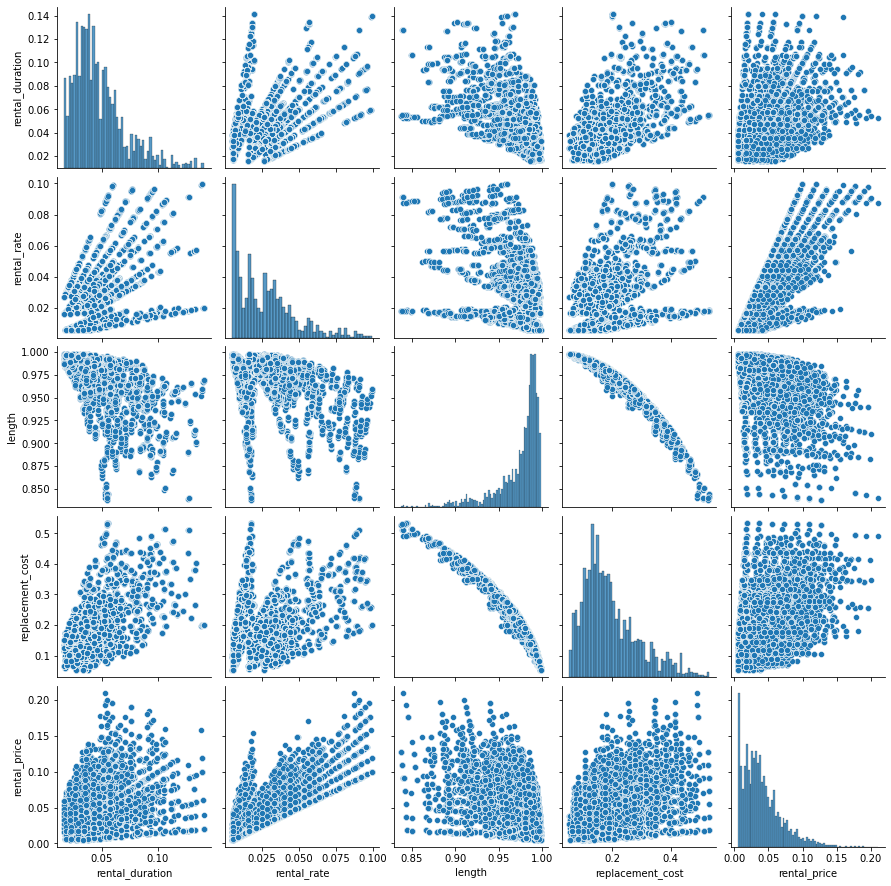

In [33]:
sns.pairplot(x)


#### Encode some categorical variables

In [34]:
#show categorical columns
df_categorical=df_sakila.select_dtypes(include='object')
df_categorical

,inventory_id,rental_id,rent_customer_id,film_id,title,rating
0,1,4863,431,1,ACADEMY DINOSAUR,PG
1,1,11433,518,1,ACADEMY DINOSAUR,PG
2,1,14714,279,1,ACADEMY DINOSAUR,PG
3,2,972,411,1,ACADEMY DINOSAUR,PG
4,2,2117,170,1,ACADEMY DINOSAUR,PG
...,...,...,...,...,...,...
16039,4581,711,215,1000,ZORRO ARK,NC-17
16040,4581,1493,235,1000,ZORRO ARK,NC-17
16041,4581,6712,226,1000,ZORRO ARK,NC-17
16042,4581,9701,401,1000,ZORRO ARK,NC-17


In [35]:
cat = df_sakila.select_dtypes(include = np.object) #include empty objects
cat.head()

C:\Users\glori\AppData\Local\Temp/ipykernel_8500/489452481.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat = df_sakila.select_dtypes(include = np.object) #include empty objects


,inventory_id,rental_id,rent_customer_id,film_id,title,rating
0,1,4863,431,1,ACADEMY DINOSAUR,PG
1,1,11433,518,1,ACADEMY DINOSAUR,PG
2,1,14714,279,1,ACADEMY DINOSAUR,PG
3,2,972,411,1,ACADEMY DINOSAUR,PG
4,2,2117,170,1,ACADEMY DINOSAUR,PG


In [36]:
cat = cat.drop(['rating'], axis=1)
cat.head()

,inventory_id,rental_id,rent_customer_id,film_id,title
0,1,4863,431,1,ACADEMY DINOSAUR
1,1,11433,518,1,ACADEMY DINOSAUR
2,1,14714,279,1,ACADEMY DINOSAUR
3,2,972,411,1,ACADEMY DINOSAUR
4,2,2117,170,1,ACADEMY DINOSAUR


In [37]:
# cat = pd.get_dummies(cat, drop_first = True)


#### Correlation matrix

In [38]:
df_numerical.corr()

,rental_duration,rental_rate,length,replacement_cost,rental_price
rental_duration,1.000000,0.034745,0.055073,-0.027173,-0.276371
rental_rate,0.034745,1.000000,0.055224,-0.064787,0.685870
length,0.055073,0.055224,1.000000,0.026976,0.018947
replacement_cost,-0.027173,-0.064787,0.026976,1.000000,-0.026725
rental_price,-0.276371,0.685870,0.018947,-0.026725,1.000000


In [39]:
corr_matrix = df_numerical.corr()

<AxesSubplot:>

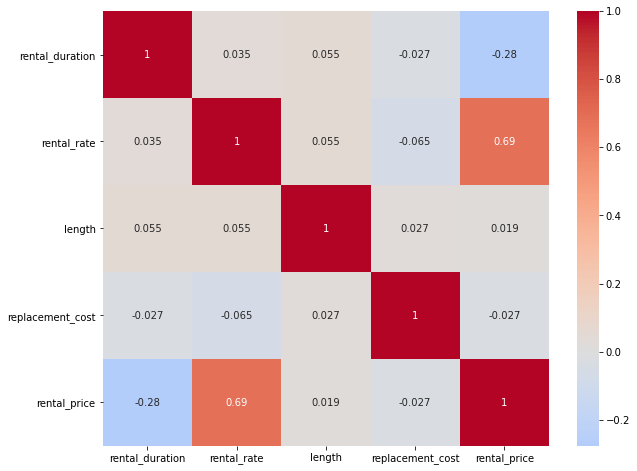

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True)

#### Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.


df_sakila['target'] = df_skills["columnname"].str.contains("thing that match and make the boolean true")

select f.title, r.rental_date
from film f 
join inventory i using (film_id)
join rental r using (inventory_id) 
WHERE r.rental_date in
(select r.rental_date from rental r
where r.rental_date>='2006-01-15%' AND r.rental_date<='2006-02-15%');

select f.title, r.rental_date
from film f
join inventory i using (film_id)
join rental r using (inventory_id) 
WHERE r.rental_date in
(select r.rental_date from rental r
where r.rental_date>='2006-01-15%' AND r.rental_date<='2006-02-15%');

#### Create a logistic regression model to predict this variable from the cleaned data.


#### Evaluate the results.

In [41]:
# accuracy, confusion, matrix

# 0   X

# 1        X

#     0    1

# X --> good prediction